In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import sklearn.feature_extraction.text as sk_text
import json
import csv
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import io 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
outfile = open('review_stars.tsv','w')
sfile = csv.writer(outfile, delimiter='\t', quoting = csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars','text'])

with open('review.json', encoding='utf-8') as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in utf-8
        sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')])
outfile.close()
df = pd.read_csv('review_stars.tsv', delimiter='\t', encoding='utf-8')

In [3]:
df = pd.read_csv('review_stars.tsv', delimiter='\t', encoding='utf-8')

In [23]:
df.head()

,business_id,stars,text
0,ujmEBvifdJM6h6RLv4wQIg,1.0,b'Total bill for this horrible service? Over $...
1,NZnhc2sEQy3RmzKTZnqtwQ,5.0,"b""I *adore* Travis at the Hard Rock's new Kell..."
2,WTqjgwHlXbSFevF32_DJVw,5.0,"b""I have to say that this office really has it..."
3,ikCg8xy5JIg_NGPx-MSIDA,5.0,"b""Went in for a lunch. Steak sandwich was deli..."
4,b1b1eb3uo-w561D0ZfCEiQ,1.0,b'Today was my second out of three sessions I ...


In [24]:
df.shape

(6685900, 3)

In [25]:
# business = pd.read_json('business.json',lines=True)
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",None
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-..."
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,"15655 W Roosevelt St, Ste 237",Goodyear,AZ,85338,33.455613,-112.395596,5.0,3,1,None,"Insurance, Financial Services","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."
4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,"4209 Stuart Andrew Blvd, Ste F",Charlotte,NC,28217,35.190012,-80.887223,4.0,4,1,"{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...","Plumbing, Shopping, Local Services, Home Servi...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ..."


In [26]:
# df_review_agg=df.groupby('business_id')['text'].sum()
df_review_agg.head()

business_id
--1UhMGODdWsrMastO9DZw    b'If you are looking for authentic Mexican str...
--6MefnULPED_I942VcFNA    b"They have the best Chinese BBQ Pork (Char Si...
--7zmmkVg-IMGaXbuVd0SQ    b"I'm a tad reluctant to write a review as I r...
--8LPVSo5i0Oo61X01sV9A    b'Dr. LaCognata is great.  He is a great liste...
--9QQLMTbFzLJ_oT-ON3Xw    b'Always great customer service. Affordable ha...
Name: text, dtype: object

In [27]:
# example of one business review 
df_review_agg[1]

'b"They have the best Chinese BBQ Pork (Char Siu) in town, and they called it Char Siu Wong (King of Chinese BBQ Pork).  Hmm... It\'s pretty true!  I\'ve to pre-order this dish every single time, cuz it\'s always sold out.\\n\\nOther dishes are very good too, like Roast Pork, Fried Glutinous Rice, Steamed Fish, etc.\\n\\nI can\'t stop myself for coming back when I\'m craving for Siu Mei"b"I come here with my gf and her family often and they never disappoint.  The food is always served fresh and with typical Chinese restaurants the service is sub par unless you are a regular customer.  The decor itself is your usual Chinese bbq house/restaurant and is nothing to go crazy over, but it\'s the food that keeps us coming back here.\\n\\nThe dishes we usually order and are their top of the line choices include their steamed fresh fish, minced pork meat pie, bitter melon and meat, steamed chicken and assorted styles of cooked vegetables with shrimp paste.  The food is served fresh and hot and 

In [28]:
# afther the aggregate function we have a Series
# df2 represents an intermediate dataframe to be merged with business
df2 = pd.DataFrame({'business_id':df_review_agg.index, 'all_reviews':df_review_agg.values})

In [29]:
# now that I have two data frames I want to merge them together
# the resulting data frame will have all the information we need
df_merge=pd.merge(df2, business,on='business_id')
df_merge.head()

,business_id,all_reviews,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...,The Spicy Amigos,821 4 Avenue SW,Calgary,AB,T2P 0K5,51.049673,-114.079977,4.0,24,1,"{'BusinessParking': '{'garage': False, 'street...","Restaurants, Mexican","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'..."
1,--6MefnULPED_I942VcFNA,"b""They have the best Chinese BBQ Pork (Char Si...",John's Chinese BBQ Restaurant,"328 Highway 7 E, Chalmers Gate 11, Unit 10",Richmond Hill,ON,L4B 3P7,43.841694,-79.399755,3.0,44,1,"{'BusinessParking': '{'garage': False, 'street...","Chinese, Restaurants","{'Monday': '11:0-22:30', 'Tuesday': '11:0-22:3..."
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r...",Primal Brewery,16432 Old Statesville Rd,Huntersville,NC,28078,35.437106,-80.843688,4.0,58,1,"{'BikeParking': 'True', 'RestaurantsPriceRange...","Breweries, Food","{'Monday': '16:0-22:0', 'Tuesday': '16:0-22:0'..."
3,--8LPVSo5i0Oo61X01sV9A,b'Dr. LaCognata is great. He is a great liste...,Valley Bone and Joint Specialists,"3941 E Baseline Rd, Ste 102",Gilbert,AZ,85234,33.378589,-111.748145,3.5,4,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Orthopedists, Doctors, Sports Medicine, Weight...","{'Monday': '8:30-16:30', 'Tuesday': '8:30-16:3..."
4,--9QQLMTbFzLJ_oT-ON3Xw,b'Always great customer service. Affordable ha...,Great Clips,"1835 E Guadalupe Rd, Ste 106",Tempe,AZ,85283,33.362813,-111.908995,3.5,12,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Beauty & Spas, Hair Salons",None


In [84]:
%pwd

'/Users/austinwilson/Desktop/CSUS/180/mini'

In [88]:
df_merge.to_excel('data.xlsx')

In [83]:
df_merge.head()

,business_id,all_reviews,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...,The Spicy Amigos,821 4 Avenue SW,Calgary,AB,T2P 0K5,51.049673,-114.079977,4.0,24,1,"{'BusinessParking': '{'garage': False, 'street...","Restaurants, Mexican","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'..."
1,--6MefnULPED_I942VcFNA,"b""They have the best Chinese BBQ Pork (Char Si...",John's Chinese BBQ Restaurant,"328 Highway 7 E, Chalmers Gate 11, Unit 10",Richmond Hill,ON,L4B 3P7,43.841694,-79.399755,3.0,44,1,"{'BusinessParking': '{'garage': False, 'street...","Chinese, Restaurants","{'Monday': '11:0-22:30', 'Tuesday': '11:0-22:3..."
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r...",Primal Brewery,16432 Old Statesville Rd,Huntersville,NC,28078,35.437106,-80.843688,4.0,58,1,"{'BikeParking': 'True', 'RestaurantsPriceRange...","Breweries, Food","{'Monday': '16:0-22:0', 'Tuesday': '16:0-22:0'..."
5,--9e1ONYQuAa-CB_Rrw7Tw,b'Very busy and noisy restaurant.\nAsparagas w...,Delmonico Steakhouse,3355 Las Vegas Blvd S,Las Vegas,NV,89109,36.123183,-115.169190,4.0,1613,1,"{'WiFi': 'u'no'', 'RestaurantsAttire': ''dress...","Cajun/Creole, Seafood, Steakhouses, Restaurants","{'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'..."
6,--DaPTJW3-tB1vP-PfdTEg,b'My sister and in laws were in town and we wa...,Sunnyside Grill,1218 Saint Clair Avenue W,Toronto,ON,M6E,43.677807,-79.444674,3.5,49,1,"{'RestaurantsDelivery': 'False', 'Ambience': '...","Restaurants, Breakfast & Brunch","{'Monday': '7:0-15:0', 'Tuesday': '7:0-15:0', ..."


In [87]:
# dropping all businesses that have less than 20 reviews (not normally distributed?)
df_merge.drop(df_merge[df_merge['review_count']<20].index,inplace=True)

In [32]:
type(df_merge[df_merge['state']=='CA'])

pandas.core.frame.DataFrame

In [35]:

##  SUBSET DATA BY STATE!!!!!! 


df_ca = df_merge[df_merge['state'] == 'CA']
df_ca

,business_id,all_reviews,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
106592,YMeWjOd1svHDGdDCKoiGgg,"b""No massives on earth rock like EDC, and ther...",Electric Daisy Carnival,7000 N Las Vegas Blvd,Los Angeles,CA,90037,36.273260,-115.009430,4.5,36,0,"{'OutdoorSeating': 'True', 'GoodForKids': 'Fal...","Local Flavor, Festivals, Arts & Entertainment,...",None
149535,lfK_nFK50w2Gr6IMZviyIQ,"b""My sister in law gifted my mother in law and...",Sabai Beauty & Wellness,"16375 Monterey Rd, Ste E",Morgan Hill,CA,95037,33.310083,-111.897002,4.0,29,1,"{'BusinessParking': '{'garage': False, 'street...","Waxing, Massage Therapy, Beauty & Spas, Hair R...","{'Monday': '10:0-18:0', 'Tuesday': '10:0-18:0'..."
152508,meK9y7zRVoN4uaf6sAC8KQ,"b""Friendly, decently priced, and my knives are...",Finest-Edge Precision Sharpening Service,,Peninsula,CA,44264,41.241167,-81.552618,5.0,22,1,{'BusinessAcceptsCreditCards': 'True'},"Local Services, Knife Sharpening",None
157134,oBEFhUe7yEH1PK25bImCWA,b'Do NOT book Adam Brooks (Brooks Photography)...,Brooks Photography,"4372 West Point Loma Blvd, Ste A",San Diego,CA,92107,36.175000,-115.136389,1.5,35,1,{'BusinessAcceptsCreditCards': 'True'},"Session Photography, Event Photography, Event ...",None


In [57]:
## Nevada 

df_nv = df_merge[df_merge['state'] == 'NV']
df_nv.head()
df_nv.shape

(14774, 15)

In [68]:
df_nv.head()

,business_id,all_reviews,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
5,--9e1ONYQuAa-CB_Rrw7Tw,b'Very busy and noisy restaurant.\nAsparagas w...,Delmonico Steakhouse,3355 Las Vegas Blvd S,Las Vegas,NV,89109,36.123183,-115.169190,4.0,1613,1,"{'WiFi': 'u'no'', 'RestaurantsAttire': ''dress...","Cajun/Creole, Seafood, Steakhouses, Restaurants","{'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'..."
10,--FBCX-N37CMYDfs790Bnw,"b""My husband and I live nearby and only stoppe...",The Bar At Bermuda & St. Rose,11624 Bermuda Rd,Henderson,NV,89052,35.978679,-115.155057,4.0,135,1,"{'OutdoorSeating': 'False', 'RestaurantsDelive...","Nightlife, Beer, Wine & Spirits, Bars, Restaur...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
31,--e8PjCNhEz32pprnPhCwQ,"b""I love this place! Don't take my Coco anywhe...",Lucky's Pet Grooming & Boutique,1460 E Charleston Blvd,Las Vegas,NV,89104,36.158851,-115.133272,3.0,29,1,None,"Pet Services, Pets, Pet Stores, Pet Groomers","{'Monday': '9:0-17:0', 'Tuesday': '9:0-17:0', ..."
48,--z7PM8AGaJP0aBmGMY7RA,"b""Nacho is the most reliable and honest mechan...",Nacho Mobile Auto Repair,2954 Westwood Dr,Las Vegas,NV,89109,36.135709,-115.175700,5.0,24,1,{'BusinessAcceptsCreditCards': 'True'},"Auto Repair, Automotive","{'Monday': '7:30-18:0', 'Tuesday': '7:30-18:0'..."
57,-0BxAGlIk5DJAGVkpqBXxg,"b""Kosher... for those who care. The cafe is 24...",The Coffee Bean & Tea Leaf,3355 Las Vegas Blvd S,Las Vegas,NV,89162,36.122935,-115.168528,3.0,44,1,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...","Food, Restaurants, Coffee & Tea",None


In [69]:
df_nv.shape

(14774, 15)

In [60]:
df_nv.city.unique()

array(['Las Vegas', 'Henderson', 'North Las Vegas', 'Summerlin',
       'Enterprise', 'Boulder City', 'LAS VEGAS',
       'Henderson (Green Valley)', 'N Las Vegas', 'C Las Vegas',
       'henderson', 'Clark', 'Central Henderson', 'Las  Vegas', 'Sunrise',
       'N W Las Vegas', 'Paradise', 'HENDERSON', 'Las Vegas & Henderson',
       'Blue Diamond', 'Spring Valley', 'South Las Vegas',
       'Centennial Hills', 'las vegas', '110 Las Vegas', 'Las vegas',
       'N E Las Vegas', 'Henderston', 'N. Las Vegas', 'NELLIS AFB',
       'Las Vegas East', 'City Center', 'LasVegas', 'Nellis AFB',
       'W Spring Valley', 'Seven Hills', 'boulder city', 'Las Vegas ',
       'W Henderson', 'Vegas', 'NORTH LAS VEGAS'], dtype=object)

In [65]:
# Arizona

df_az = df_merge[df_merge['state']=='AZ']
df_nm.shape

(0, 15)

In [67]:
df_az.all_reviews.shape

(18610,)

In [63]:
df_nm.describe()

,latitude,longitude,stars,review_count,is_open
count,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN


In [78]:
# North Carolina

df_nc = df_merge[df_merge['state']=='NC']

In [79]:
df_nc.head()

,business_id,all_reviews,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r...",Primal Brewery,16432 Old Statesville Rd,Huntersville,NC,28078,35.437106,-80.843688,4.0,58,1,"{'BikeParking': 'True', 'RestaurantsPriceRange...","Breweries, Food","{'Monday': '16:0-22:0', 'Tuesday': '16:0-22:0'..."
28,--cZ6Hhc9F7VkKXxHMVZSQ,b'Food was good. Got the #20 lunch combo. At f...,Pio Pio,1408 E Blvd,Charlotte,NC,28203,35.199853,-80.844820,4.0,346,1,"{'RestaurantsDelivery': 'True', 'Alcohol': 'u'...","Restaurants, Spanish, Peruvian, Colombian, Lat...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
188,-2pQf1ceDZyE2ReCNbj-3A,"b""I love Just Fresh, I've been to different lo...",Just Fresh,14136 Rivergate Pkwy,Charlotte,NC,28273,35.102031,-80.985337,3.5,61,1,"{'Ambience': '{'romantic': False, 'intimate': ...","American (Traditional), Breakfast & Brunch, Fo...","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
189,-2pmn-oTJeybmDrL-ojwrw,"b""These guys are great. I try and stay as obje...",New Wrap Order,,Charlotte,NC,28211,35.166003,-80.793480,4.5,21,1,"{'RestaurantsReservations': 'False', 'Restaura...","Food Trucks, Wraps, Food, Street Vendors, Rest...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-17:0', '..."
299,-5KBZ3UmQzW_PkrjHGMuUg,"b""I've now stayed at this place for two separa...",Econo Lodge Inn & Suites Airport,3415 Queen City Drive,Charlotte,NC,28208,35.239875,-80.922149,2.5,32,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Event Planning & Services, Hotels & Travel, Ho...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."


In [80]:
df_nc.shape

(4084, 15)

In [82]:
df_nc.latitude.unique()

array([35.437106  , 35.19985284, 35.1020312 , ..., 35.137223  ,
       35.22095   , 35.4101165 ])

In [ ]:
# 

In [13]:
# tfidf stuff 
corpus=df_merge['all_reviews']
vectorizer=sk_text.TfidfVectorizer(stop_words='english', max_features=5000, min_df=5)
matrix=vectorizer.fit_transform(corpus)
tfidf_data=matrix.toarray()

In [14]:
# numpy array of all the tfidf values for each business 
tfidf_data=matrix.toarray()

In [15]:
tfidf_data.shape

(57644, 5000)


# ADD MORE FEATURES HERE
# one feature could be review_count

In [89]:
# train/test split
# 9 is the location of the stars review in the dataframe
x=tfidf_data
y=df_merge.iloc[:,9].values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=0)

In [90]:
# adding a new column to x to get lower rmse
# x2 = np.column_stack((x,np.array(df_merge['review_count'])))
# x_train2, x_test2, y_train2, y_test2 = train_test_split(x2,y,test_size=.2,random_state=0)

In [91]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(46115, 5000)
(46115,)
(11529, 5000)
(11529,)


In [92]:
checkpointer=ModelCheckpoint(filepath='dnn/best_weights1.hdf5',verbose=0,save_best_only=True)
model=Sequential()
model.add(Dense(25, input_dim=x.shape[1],activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=2,verbose=2,mode='auto')

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

Train on 46115 samples, validate on 11529 samples
Epoch 1/100
46115/46115 - 9s - loss: 0.6181 - val_loss: 0.1519
Epoch 2/100
46115/46115 - 4s - loss: 0.1131 - val_loss: 0.1076
Epoch 3/100
46115/46115 - 4s - loss: 0.0855 - val_loss: 0.0918
Epoch 4/100
46115/46115 - 4s - loss: 0.0771 - val_loss: 0.0880
Epoch 5/100
46115/46115 - 4s - loss: 0.0725 - val_loss: 0.0907
Epoch 6/100
46115/46115 - 4s - loss: 0.0700 - val_loss: 0.0849
Epoch 7/100
46115/46115 - 4s - loss: 0.0677 - val_loss: 0.0857
Epoch 8/100
46115/46115 - 4s - loss: 0.0663 - val_loss: 0.0851
Epoch 00008: early stopping


In [93]:
pred = model.predict(x_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test,pred))

In [94]:
rmse

0.2917069611945899

In [95]:
# checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

# for i in range(5):
#     print(i)

#     checkpointer=ModelCheckpoint(filepath='dnn/best_weights1.hdf5',verbose=0,save_best_only=True)
#     model=Sequential()
#     model.add(Dense(25, input_dim=x.shape[1],activation='relu'))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error',optimizer='adam')
#     monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=2,verbose=2,mode='auto')

#     model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
# # model.load_weights('/dnn/best_weights.hdf5')

In [96]:
pred=model.predict(x_test)

In [97]:
rmse=np.sqrt(metrics.mean_squared_error(pred,y_test))

In [98]:
rmse

0.2917069611945899

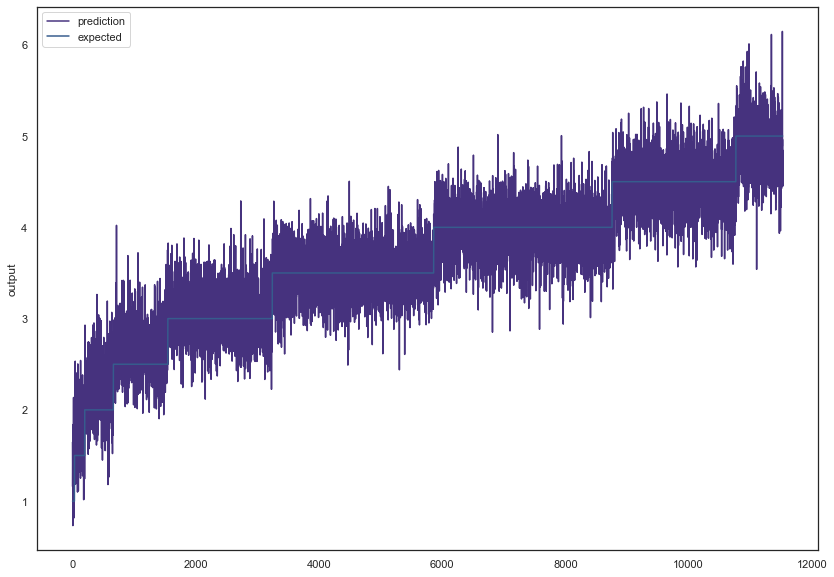

In [120]:
def chart_regression(pred,y,sort=True):
    plt.figure(figsize = (14,10))
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    b = plt.plot(t['pred'].tolist(),label='prediction')
    a = plt.plot(t['y'].tolist(),label='expected')

    plt.ylabel('output')
    plt.legend()
    plt.show()
    return t

y_pred_y_test=chart_regression(pred.flatten(),y_test,sort=True)

In [100]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
r2 = r2_score(y_test,pred)
r2

0.86735105070182

In [101]:
mae = mean_absolute_error(y_test,pred)
mae

0.22814183364831436

In [121]:
y_pred_y_test.head()

,pred,y
6149,1.162172,1.0
2462,1.483182,1.0
4356,1.647925,1.0
3351,1.457308,1.0
674,1.403912,1.0


ValueError: Either both or neither of `x` and `y` must be specified (but try passing to `data`, which is more flexible).

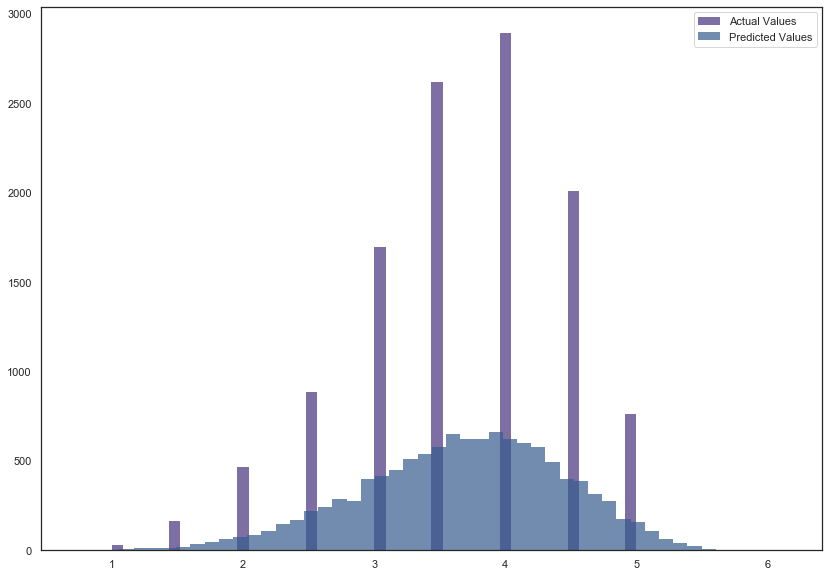

In [112]:
import seaborn as sns
plt.figure(figsize = (14,10))
sns.set(palette = "viridis")
sns.set_style("white")
sns.distplot(y_test,
             label = "test values",
             kde = False,
             # bins = 500, # can play with this 
             hist_kws = {"edgecolor" : 'none', "alpha" : 0.7 })
sns.distplot(pred,
             label = "pred values",
             kde = False,
             # bins = 500, # can play with this 
             hist_kws = {"edgecolor" : 'none', "alpha" : 0.7 })
plt.legend(["Actual Values", "Predicted Values"])
plt.show()

In [ ]:
df_merge.head()

In [ ]:
austins_idea = df_merge[['all_reviews','review_count','stars']]

In [ ]:
print(austins_idea)

In [ ]:
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    df = pd.DataFrame()
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    # df.drop(name, axis=1, inplace=True)
    return df

In [ ]:
encoded_results = encode_text_dummy(austins_idea,'stars')

In [ ]:
encoded_results

In [ ]:
# this is the y data 
encoded_results_np = encoded_results.to_numpy()

In [ ]:
# this is the x data 
tfidf_data

In [ ]:
# x_cl is for x classification
# y_cl is for y classification
x_cl = tfidf_data
y_cl = encoded_results_np

In [ ]:
print(x_cl.shape)
print(y_cl.shape)

In [ ]:
x_cl_train, x_cl_test, y_cl_train, y_cl_test = train_test_split(x_cl,y_cl,test_size=.2,random_state=0)

In [ ]:
print(x_cl_train.shape)
print(y_cl_train.shape)
print(x_cl_test.shape)
print(y_cl_test.shape)

In [ ]:
model2 = Sequential()
model2.add(Dense(10,input_dim=x_cl.shape[1],activation='relu'))
model2.add(Dense(y_cl.shape[1],activation='softmax'))
model2.compile(loss='categorical_crossentropy',optimizer='adam')

In [ ]:
model2.fit(x_cl,y_cl,verbose=2,epochs=10)

In [ ]:
y_pred2 = model2.predict(x_cl_test)

In [ ]:
rmse2 = np.sqrt(metrics.mean_squared_error(y_pred,y_cl_test))
print(rmse2)

In [ ]:
r2_cl = r2_score(y_test,pred)
r2_cl